**Upload Kaggle API Key JSON File (Run This Cell First, Then Run The Rest)**

In [1]:
from google.colab import files
files.upload()

Saving shoe-vs-sandal-vs-boot-dataset-15k-images.zip to shoe-vs-sandal-vs-boot-dataset-15k-images.zip


**Download Files From Kaggle**

*Install Kaggle*

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Moving Key to Correct Directory to Use Kaggle*

In [3]:
!mkdir ~/.kaggle

In [4]:
!mv kaggle.json ~/.kaggle/

*Download Shoe Dataset*

In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

shoe-vs-sandal-vs-boot-dataset-15k-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip && mv 'Shoe vs Sandal vs Boot Dataset' dataset

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

**Separating Images into Test, Validation, and Training Folders**

In [7]:
from pathlib import Path
import random

random.seed(911911)

#get the file paths for each of the classes in /content/dataset
cDirectories = [ c for c in Path("/content/dataset").iterdir()]

#get all files
bootFiles = [boot for boot in Path("/content/dataset/Boot").iterdir()]
sandalFiles = [sandal for sandal in Path("/content/dataset/Sandal").iterdir()]
shoeFiles = [shoe for shoe in Path("/content/dataset/Shoe").iterdir()]

files = bootFiles + sandalFiles + shoeFiles

#randomize files
random.shuffle(files)

In [8]:
#Create new destination folders
split = ["training", "validation", "testing"]
Path("/content/output").mkdir(parents=True, exist_ok=True)
for i in split:
  Path("/content/output/" +  i +"/Boot").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Sandal").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Shoe").mkdir(parents=True, exist_ok=True)


In [9]:
import shutil

#Move files to new folders
trainNum = int(0.8* len(files))
testNum = int(0.1* len(files))
validNum = int(0.1* len(files))
count = 0
curFolder = split[0]
for file in files:
  if( count < trainNum ):
    curFolder = split[0]
  elif( count < trainNum + testNum ):
    curFolder = split[1]
  else:
    curFolder = split[2]
  shutil.move( str(file) , "/content/output/" + curFolder + "/" + file.parts[3])
  count = count + 1

**Imports**

In [10]:
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers

**Preprocessing**

*Setup Image Generators for Data Augmentation and Rescaling*

In [11]:
trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0,
  horizontal_flip=True,
  rotation_range=50,
)

testGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0
)

*Specify Directory of Images, Resize, and Specify Batch Size*

In [12]:
trainData = trainGen.flow_from_directory(
  '/content/output/training',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse"
)

validData = testGen.flow_from_directory(
  '/content/output/validation',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse"
)

testData = testGen.flow_from_directory(
  '/content/output/testing',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse",
  shuffle = False
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


*Examples of Augmented Images*

In [13]:
image, label = next(trainData)
trainData.reset()

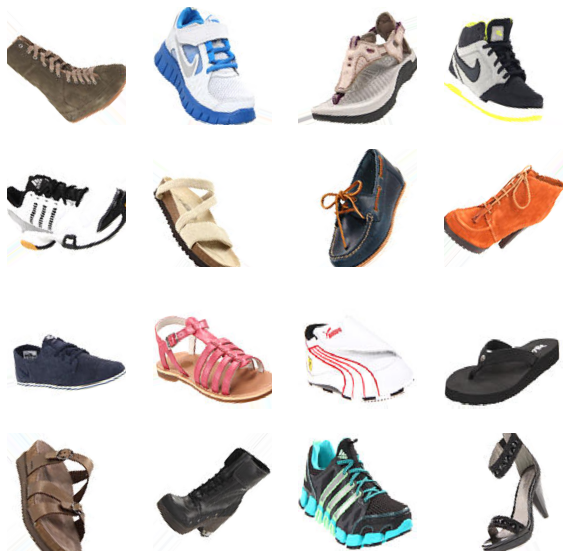

In [14]:
fig = plt.figure(figsize=(10, 10))
for i in range(0, 16):
    img = image[i]
    fig.add_subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

**Model**

*AlexNet*

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import numpy as np

model = tf.keras.models.Sequential()

#1st Conv
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding = "same", input_shape=[224, 224, 3]))
model.add(MaxPooling2D(pool_size=3, strides=2))

#2nd Conv
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=3, strides=2))


#3rd Conv
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same")) 


#4th Conv
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding = "same"))

#5th Conv
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=3, strides=2))

#Flat
model.add(Flatten())

model.add(Dense(units=128, activation="relu"))
tf.keras.layers.Dropout(0.5)

model.add(Dense(units= 10, activation= "softmax"))





In [ ]:
#model = tf.keras.models.load_model("random.h5")

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 32)        1

In [17]:
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [18]:
training_info = model.fit(trainData, validation_data = validData, epochs = 15, verbose = 1)

model.save("EdsNet.h5")

Epoch 1/15
375/375 [==============================] - 138s 344ms/step - loss: 0.7764 - accuracy: 0.6488 - val_loss: 0.5136 - val_accuracy: 0.7820
Epoch 2/15
375/375 [==============================] - 129s 345ms/step - loss: 0.5020 - accuracy: 0.7950 - val_loss: 0.4767 - val_accuracy: 0.7887
Epoch 3/15
375/375 [==============================] - 128s 340ms/step - loss: 0.3936 - accuracy: 0.8425 - val_loss: 0.3178 - val_accuracy: 0.8760
Epoch 4/15
375/375 [==============================] - 129s 343ms/step - loss: 0.3295 - accuracy: 0.8718 - val_loss: 0.2609 - val_accuracy: 0.9067
Epoch 5/15
375/375 [==============================] - 129s 343ms/step - loss: 0.2951 - accuracy: 0.8887 - val_loss: 0.2738 - val_accuracy: 0.8933
Epoch 6/15
375/375 [==============================] - 128s 341ms/step - loss: 0.2617 - accuracy: 0.9007 - val_loss: 0.2255 - val_accuracy: 0.9133
Epoch 7/15
375/375 [==============================] - 128s 342ms/step - loss: 0.2324 - accuracy: 0.9130 - val_loss: 0.1761 -

In [ ]:
# model = keras.Model(inputs=inputs, outputs=m, name="EdsNet")

**Visualization of Training and Validation Loss**

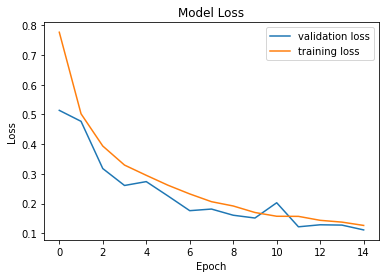

In [19]:
plt.plot(training_info.history["val_loss"])
plt.plot(training_info.history["loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation loss', 'training loss'], loc='upper right')

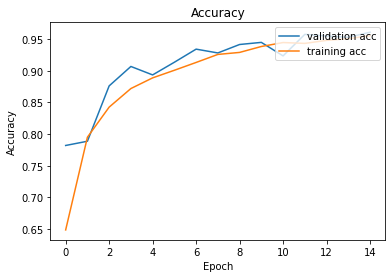

In [20]:
plt.plot(training_info.history["val_accuracy"])
plt.plot(training_info.history["accuracy"])
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation acc', 'training acc'], loc='upper right')

**Testing**

*Evaluating the Model with Test Data*

In [21]:
result = model.evaluate(testData)

47/47 [==============================] - 2s 43ms/step - loss: 0.0955 - accuracy: 0.9640


*View the Model's Predictions on a part of the Test Data*

In [22]:
testData.reset()
labels = np.concatenate([testData.next()[1] for i in range(testData.__len__())])
images = np.concatenate([testData.next()[0] for i in range(testData.__len__())])
np.random.seed(420)
np.random.shuffle(labels)
np.random.seed(420)
np.random.shuffle(images)

47/47 [==============================] - 1s 28ms/step


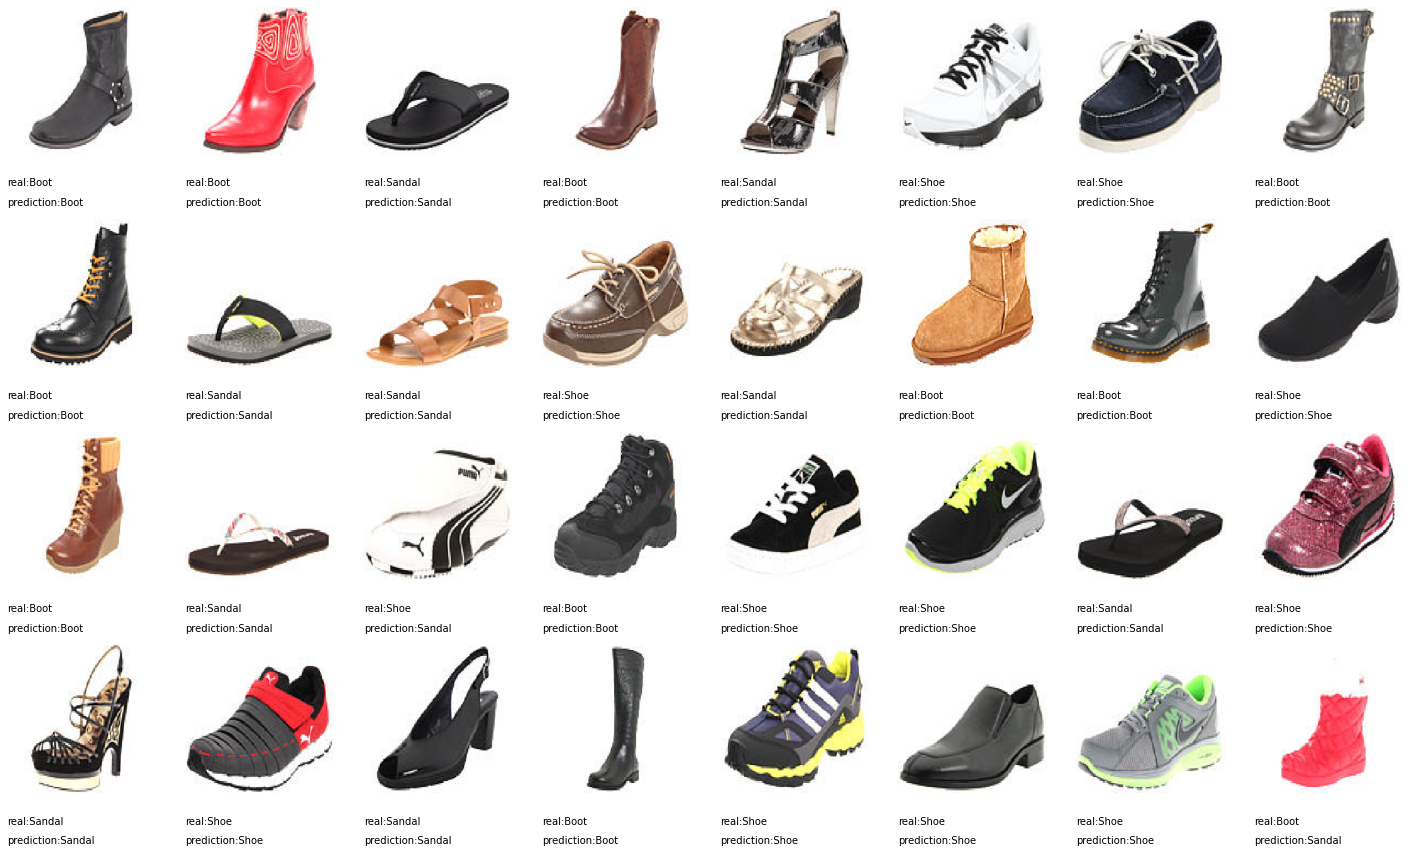

In [23]:
softpred = model.predict(images)
pred = np.argmax(softpred, axis=1)

class_names = ["Boot", "Sandal", "Shoe"]
fig = plt.figure(figsize = (25,15))
for i in range(0, 32):
  img = images[i]
  fig.add_subplot(4,8, i+1)
  plt.imshow(img)
  plt.text(0,270,"real:" +class_names[int(labels[i])])
  plt.text(0,300, "prediction:" +class_names[pred[i]])
  plt.axis("off")
plt.show()

*View Misclassified Examples*

In [24]:
testData.reset()
labels = np.concatenate([testData.next()[1] for i in range(testData.__len__())])
images = np.concatenate([testData.next()[0] for i in range(testData.__len__())])

In [25]:
softpred = model.predict( images )
pred = np.argmax(softpred, axis = 1)

47/47 [==============================] - 1s 27ms/step


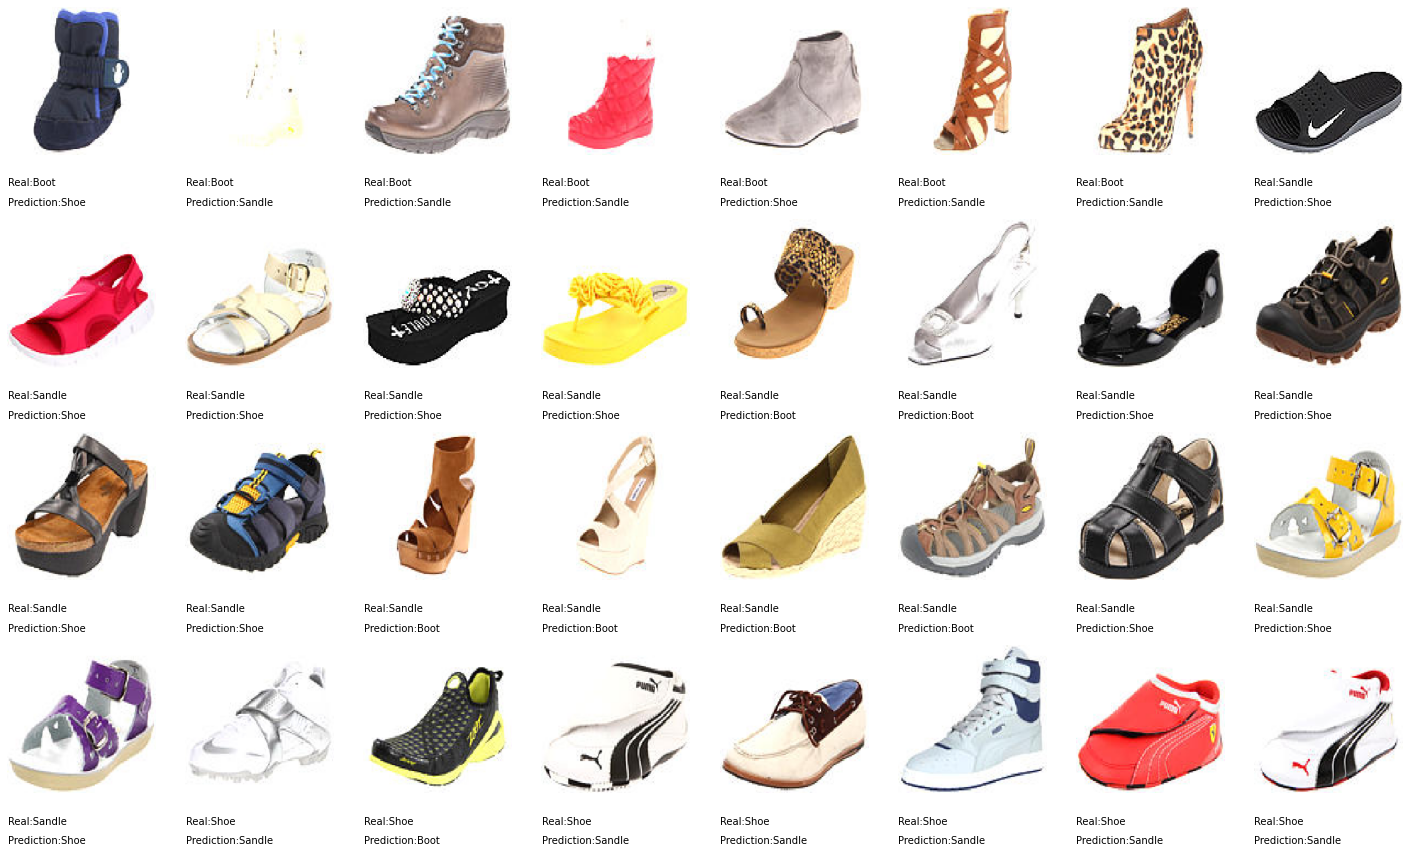

In [26]:
class_names = ["Boot", "Sandle", "Shoe"]
fig = plt.figure(figsize=(25, 15))
count = 0;
for i in range(0, 1472):
    img = images[i]
    labelPred = class_names[int(labels[i])]
    labelReal = class_names[pred[i]]
    if labelPred != labelReal and count < 32:  
      fig.add_subplot(4, 8, count+1)
      plt.imshow(img)
      plt.text(0, 270, "Real:" + labelPred)
      plt.text(0, 300, "Prediction:" + labelReal)
      count+=1
      plt.axis("off")
plt.show()